# Yelp Dataset (2017) Sentiment Analysis - Predicting Star Ratings 
The dataset can be downloaded from https://www.yelp.com/dataset/challenge 
This notebook is a trimmed down and simplified version of the submitted courswork, it also contains additional comments that should make it easier for beginners to understand what's going on. 

We use two approaches to conduct sentiment analysis on the review data:
1. Positive and negative word counts based on a sentiment lexicon with Random Forest as a classifier. 
2. Bag-of-word representation with multinominal naive bayes as a classifier

The original dataset is quite large (3.6 GB) and most consumer grade laptops and desktops will not have enough memory to work with a dataset of this size. There are on-line methods (e.g. partial_fit in sklearns multinominal NB) that can be used instead but training a model in an on-line fashion takes much longer. For easier reproducibility we will use a 10k sample of the orginal dataset (in the orginal courswork I used the full dataset on a AWS instance with 64GB of memory).

In [104]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from langdetect import DetectorFactory
from langdetect import detect
from scipy.stats import pearsonr,spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

## 1. Download datasets and convert json to csv
We will use the sentiment lexicon by Hu, Minqing and Bing Liu (2004). <br>
“Mining and Summarizing Customer Reviews”. In: Proceedings of the Tenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. KDD ’04. New York, NY, USA: ACM, pp. 168–177. isbn: 978-1-58113-888-7. doi: 10.1145/1014052.1014073. url: http://doi.acm.org/10.1145/1014052.1014073.

In [ ]:
# download sentiment lexicon
!mkdir data
!wget -P data http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
!unrar e data/opinion-lexicon-English.rar

In [8]:
# download review dataset from https://www.yelp.com/dataset/challenge (requires registration)
!ls data

negative-words.txt          positive-words.txt
opinion-lexicon-English.rar review_10k.json


In [34]:
raw_json = 'data/review_10k.json'
raw_csv = 'data/review_10k.csv'
positive_words_path = 'data/positive-words.txt'
negative_words_path = 'data/negative-words.txt'

In [11]:
# read review.json
review = pd.read_json(raw_json,encoding='utf8',lines=True)
# reorder and drop review_id business_id and user_id
review.drop(['review_id','business_id','user_id'],axis=1,inplace=True)
review = review[['date','text','stars','useful','funny','cool']]
# save to disk so that we only have to make this conversion once
review.to_csv(raw_csv,index=False)

# 2. Preprocessing 
Before applying our two classifier we first have to clean the data. The complete dataset contains reviews in various languages, since we are using an English sentiment lexicon we have to remove all non-english reviews. Additionally the review text contains left-over html markup snippets that need to be removed. Further we standardize and simplify the used emoji, e.g :-) becomes :). 

In [13]:
# read the csv version
review = pd.read_csv(raw_csv)

In [21]:
# detect language of review using the langdetect python package
DetectorFactory.seed = 0
# modefied detect to handle exception errors when useing pandas .apply function
def langdemod(inputtext):
    try: return detect(inputtext)
    except: return np.nan

review['language'] = review['text'].apply(langdemod)

In [22]:
# percentages of languages present
review.groupby('language').size().apply(lambda x: (x/review.groupby('language').size().sum())*100).sort_values(ascending=False)

language
en       98.59
de        0.81
fr        0.42
es        0.04
zh-tw     0.03
it        0.03
nl        0.02
ja        0.02
tl        0.01
so        0.01
pt        0.01
da        0.01
dtype: float64

In [23]:
# only keep english reviews
review = review.loc[review['language'] == 'en']

In [95]:
# remove unwanted html markup and standardizes the used emojis and append them at the end of the text.
# adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/optional-py-scripts/ch08.py. 
import re
def cleaner(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text) +' ' +' '.join(emoticons).replace('-','')
    return text

# try funciton on an example text snipped
print(cleaner('</a>This :) is :-( a Test'))

This is a Test :) :(


In [26]:
# apply cleaner
review['text'] = review['text'].apply(cleaner)

In [76]:
# Count number of positive and negative words using the sentiment lexicon

# define textsplitter
def textsplitter(text):
    """
    input: string (e.g. review text)
    returns: lowercase list of words
    """
    return text.lower().split()

# split text into list for word counting
review['wordlist'] = review['text'].apply(textsplitter)
# count words
review['words'] = review['text'].str.len()

# open sentiment lexicon
# make sure to delete the header before reading the list
po_file = open(positive_words_path, 'r',encoding='ISO-8859-1')
ne_file = open(negative_words_path, 'r',encoding='ISO-8859-1')
positive_words = open(positive_words_txt, 'r',encoding='ISO-8859-1').read().split()
negative_words = open(negative_words_txt, 'r',encoding='ISO-8859-1').read().split()

# define counter functions
def lexi_word_counter(text,sentimentlist):
    cnt = 0
    for word in text:
        if word in sentimentlist:
            cnt += 1
    # sum of all negative words in row
    return cnt

review['neg_words'] = review['wordlist'].apply(lexi_word_counter,args=(negative_words,))
review['pos_words'] = review['wordlist'].apply(lexi_word_counter,args=(positive_words,))

In [77]:
# check for nan values
review[review.isnull().any(axis=1)]

,date,text,stars,useful,funny,cool,language,textlength,wordlist,words,neg_words,pos_words


## 3. Exploratory Data Analysis

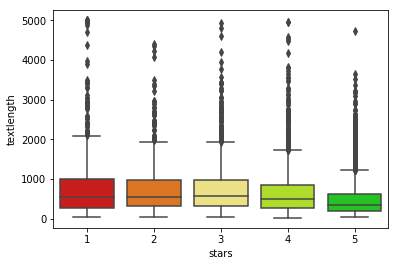

In [40]:
# Traffic light palette for 1 - 5 stars
custompal = sns.xkcd_palette(['red', 'orange', 'sandy yellow', 'yellowgreen', 'vibrant green'])
# Boxplot 'Stars' vs 'Textlenght'
dx = sns.boxplot(x='stars',y='textlength',data=review,palette=custompal)

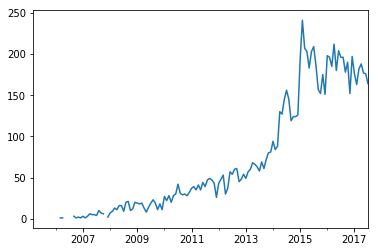

In [41]:
# Reviews over time
review['date'] = pd.to_datetime(review['date'])
datecounts = review['date'].value_counts()
datecounts.resample('M').sum().plot()

In [59]:
review.head()

,date,text,stars,useful,funny,cool,language,textlength,wordlist,words,neg_words,pos_words
0,2016-07-12,My girlfriend and I stayed here for 3 nights a...,5,0,0,0,en,1150,"[my, girlfriend, and, i, stayed, here, for, 3,...",1130,54,68
1,2016-10-02,If you need an inexpensive place to stay for a...,3,0,0,0,en,902,"[if, you, need, an, inexpensive, place, to, st...",872,40,45
3,2016-08-21,Location is everything and this hotel has it T...,4,0,0,0,en,809,"[location, is, everything, and, this, hotel, h...",801,38,45
6,2015-02-21,Beautiful space great location staff rock Tiny...,4,0,0,0,en,193,"[beautiful, space, great, location, staff, roc...",185,7,10
7,2013-07-07,This is a fairly new property I think It is a ...,4,0,0,0,en,364,"[this, is, a, fairly, new, property, i, think,...",359,14,16


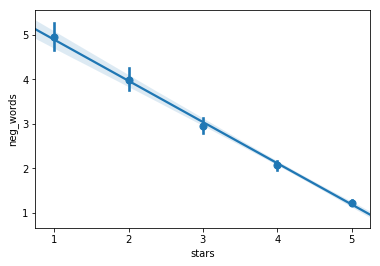

In [79]:
# plot the number of negative words vs rating
ax = sns.regplot(x="stars", y="neg_words", data=review,x_bins=np.arange(1,6))

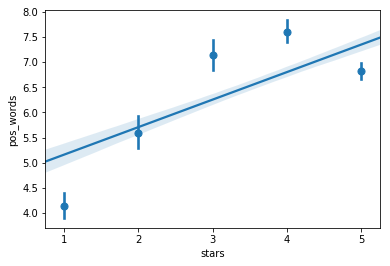

In [88]:
# plot the number of positive words vs rating
ax = sns.regplot(x="stars", y="pos_words", data=review,x_bins=np.arange(1,6))

In [81]:
pearson_neg_vs_stars = pearsonr(review['neg_words'],review['stars'])[0]
pearson_neg_vs_stars_p = pearsonr(review['neg_words'],review['stars'])[1]
pearson_pos_vs_stars = pearsonr(review['pos_words'],review['stars'])[0]
pearson_pos_vs_stars_p = pearsonr(review['pos_words'],review['stars'])[1]
print(f'Pearson cor. negative words vs stars = {pearson_neg_vs_stars}, p-value = {pearson_neg_vs_stars_p}')
print(f'Pearson cor. positive words vs stars = {pearson_pos_vs_stars}, p-value = {pearson_pos_vs_stars_p}')

Pearson cor. negative words vs stars = -0.39738574724229764, p-value = 0.0
Pearson cor. positive words vs stars = 0.1376776796101678, p-value = 6.346210126663764e-43


Notice that for negative words the mean is strictly decreasing, whereas for positive words vs stars the means resemble an inverse quadratic function, with the average number of positive words slightly decreasing from the 4 stars to the 5 stars category. Recall from the above boxplot 'Stars' vs 'Textlenght' that for five star ratings the review length was less than for other categories - in order to account for review length the ratio of positive and negative words w.r.t to the review length is a better measure

In [92]:
# to account for differences in review length we calculate the ratio of sentiment words and review length
review['neg_ratio'] = review['neg_words']/review['words']*100
review['pos_ratio'] = review['pos_words']/review['words']*100

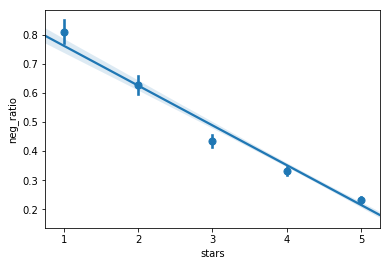

In [90]:
ax = sns.regplot(x="stars", y="neg_ratio", data=review,x_bins=np.arange(1,6))

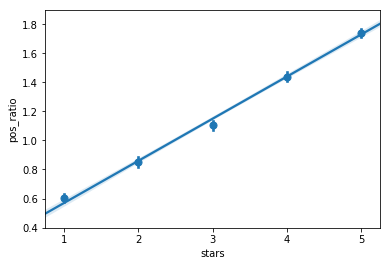

In [91]:
ax = sns.regplot(x="stars", y="pos_ratio", data=review,x_bins=np.arange(1,6))

In [97]:
pearson_negR_vs_stars = pearsonr(review['neg_ratio'],review['stars'])[0]
pearson_negR_vs_stars_p = pearsonr(review['neg_ratio'],review['stars'])[1]
pearson_posR_vs_stars = pearsonr(review['pos_ratio'],review['stars'])[0]
pearson_posR_vs_stars_p = pearsonr(review['pos_ratio'],review['stars'])[1]
print(f'Pearson cor. negative words vs stars = {pearson_negR_vs_stars}, p-value = {pearson_negR_vs_stars_p}')
print(f'Pearson cor. positive words vs stars = {pearson_posR_vs_stars}, p-value = {pearson_posR_vs_stars_p}')

Pearson cor. negative words vs stars = -0.42321027580280907, p-value = 0.0
Pearson cor. positive words vs stars = 0.4469778204530884, p-value = 0.0


This looks much better! 

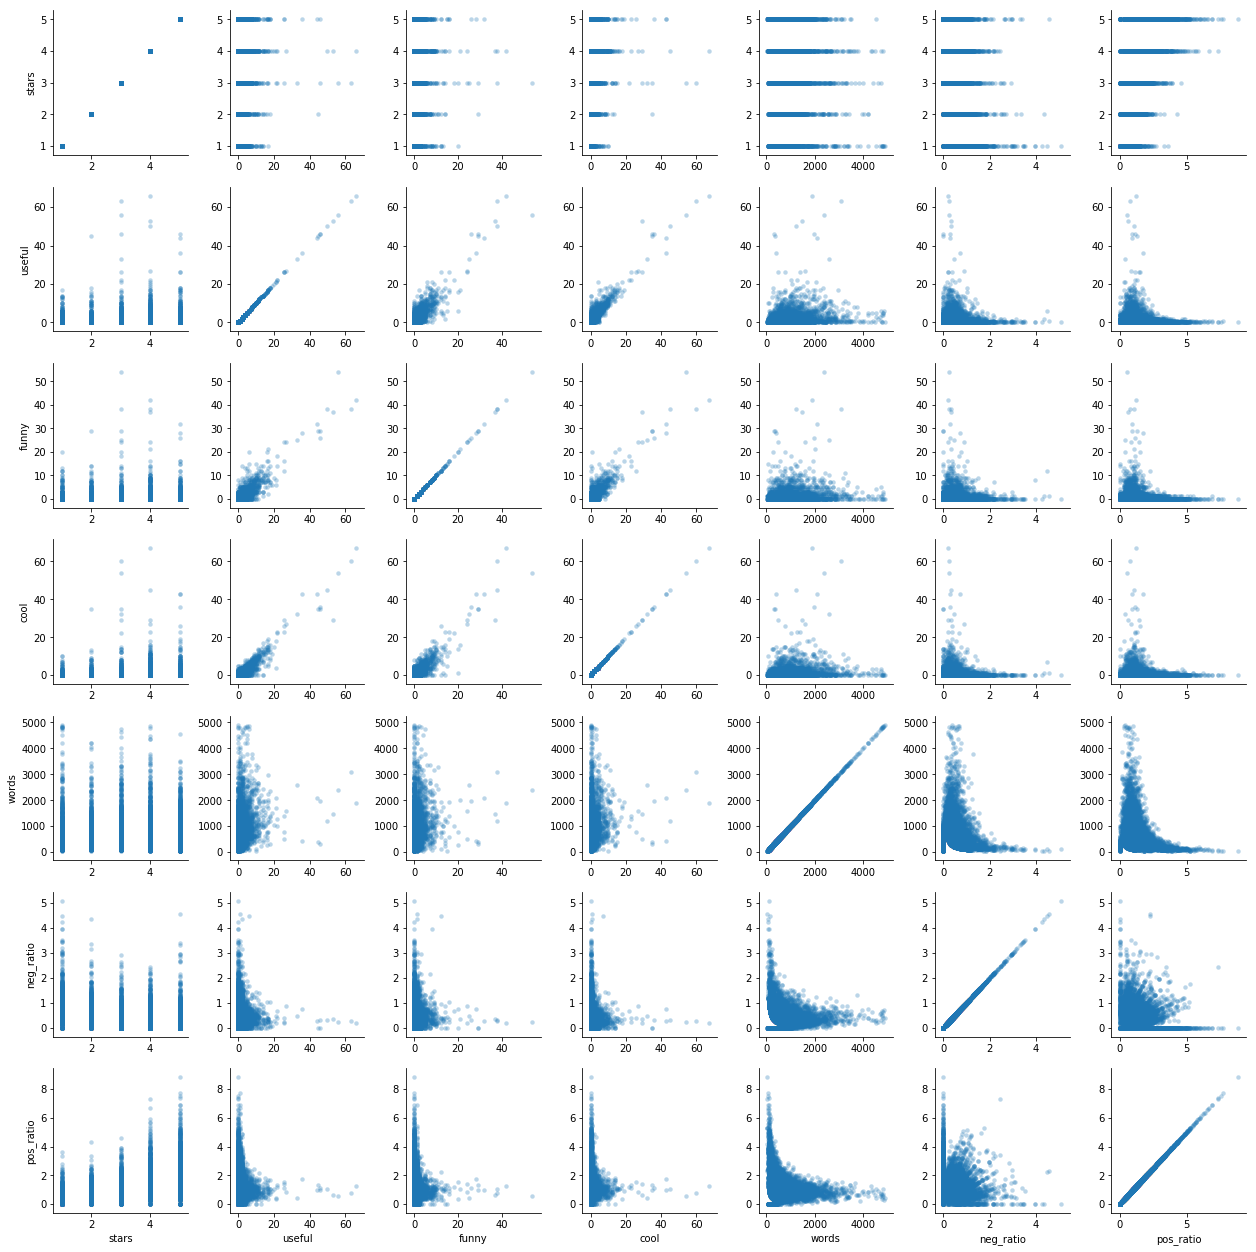

In [101]:
# display the correlation between our variables
g = sns.PairGrid(review, vars=["stars","useful", "funny","cool","words","neg_ratio","pos_ratio"])
g.map(plt.scatter,s=20,linewidth=0,alpha=0.3);

This gridplot is mainly for illustration purpose as we will not go into detailed analysis of other features such as if a review was marked funny or cool to predict the review ratings. However these charateristics could be used as a ground-truth for a more complex language processing analysis; for example it would be interesting to know if we can predict the 'usefullness' of a review based purely on it's text.

## Random Forest Sentiment Classification
We train a random forest with the ratios of positive and negative words as our inputs and three sentiment groups as our target output.

In [112]:
# Group stars into sentiment categories
def stars_to_sentiment(x):
    if x >= 4:
        return 'positive'
    elif x<=2:
        return 'negative'
    else:
        return 'neutral'

review['sentiment'] = review['stars'].apply(stars_to_sentiment)

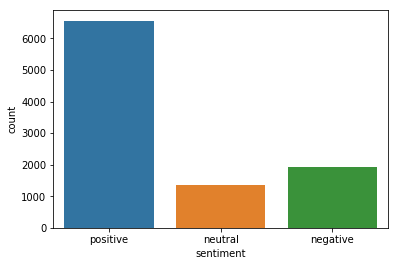

In [121]:
# display distribution 
dx = sns.countplot(x='sentiment',data=review)

In [119]:
# Train-Test Split
X = review[['neg_ratio','pos_ratio']]
y = review['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
# fit random forest classifier with 600 trees 
rf = RandomForestClassifier(n_estimators=600)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.51      0.51      0.51       389
    neutral       0.18      0.10      0.13       300
   positive       0.76      0.83      0.79      1283

avg / total       0.62      0.66      0.63      1972



The average precision of 0.62 is not great but at least the classifier does relativly good job in prediction positive ratings. On the complete dataset I achieved precisions of 0.70 (negative,0.19 (neutral),0.82 (positive) and 0.73 (average) which is considerably better. 

## Multinominal Naive Bayes Sentiment Classification
Instead of using our manual created ratios for positive and negative words, we'll use a bag-of-words representation of the review text to train a multinominal naive bayes classifier

In [126]:
#review_en = pd.read_csv('review_en.csv')
X = review['text']
# transform X into bow
countv = CountVectorizer()
X_bow = countv.fit_transform(X)
y = review['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_bow, y,test_size=0.3,random_state=101)
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

   negative       0.72      0.74      0.73       576
    neutral       0.42      0.23      0.29       434
   positive       0.84      0.92      0.88      1948

avg / total       0.76      0.78      0.76      2958



The Multinomial Naive Bayes classifier outperformed our earlier Random Forest on all measures. This is quite an interesting result and highlighst the power of the simple naive bayes classifier in combination with the bag-of-words vector representation. 